In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/la-crime/processed_data.csv


In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import lightgbm as lgb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [56]:
df = pd.read_csv("/kaggle/input/la-crime/processed_data.csv")

In [57]:
# Loại bỏ các hàng có Vict Age < 0
df = df[df["Vict Age"] >= 0]

In [58]:
# Phân loại độ tuổi thành các nhóm
def group_age(row):
    if row['Vict Age'] <= 20:
        return 0 #'Group 1 (0-20)'
    # if row['Vict Age'] <= 20:
    #     return 1 #'Group 2 (1-20)'
    # elif row['Vict Age'] <= 30:
    #     return 2 #'Group 3 (21-30)'
    elif row['Vict Age'] <= 40:
        return 1 #'Group 3 (31-40)'
    # elif row['Vict Age'] <= 50:
    #     return 4 #'Group 5 (41-50)'
    else:
        return 2 #'Group 7 (50+)'

# Áp dụng hàm để tạo nhóm tuổi
df['Age Group'] = df.apply(group_age, axis=1)

In [59]:
df['Age Group'].value_counts()

Age Group
1    362477
0    297315
2    293158
Name: count, dtype: int64

# TIỀN XỬ LÝ DỮ LIỆU

In [60]:
# các cột cần xoá
drop_lst = ['DR_NO', 'Date Rptd', 'DATE OCC', 'AREA NAME',
       'Crm Cd Desc'
       ,'Premis Desc', "Vict Age"
        , 'Weapon Desc', "Status Desc", "Status Desc", "LOCATION",
       'LAT', 'LON']

In [61]:
# xoá cột 
df = df.drop(columns=drop_lst)
df.head()

,TIME OCC,AREA,Rpt Dist No,Part 1-2,Crm Cd,Vict Sex,Vict Descent,Premis Cd,Weapon Used Cd,Status,Distance,Year OCC,Month OCC,Quarter OCC,Year Rptd,Month Rptd,Quarter Rptd,Duration,Age Group
0,2130,7,784,1,510,M,O,101.0,0.0,AA,9.984058,2020,3,1,2020,3,1,0,0
1,1800,1,182,1,330,M,O,128.0,0.0,IC,1.961858,2020,2,1,2020,2,1,1,2
2,1700,3,356,1,480,X,X,502.0,0.0,IC,6.256227,2020,11,4,2020,11,4,7,0
3,2037,9,964,1,343,M,O,405.0,0.0,IC,21.440517,2020,3,1,2023,5,2,1156,0
4,1200,6,666,2,354,M,H,102.0,0.0,IC,9.048615,2020,8,3,2022,8,3,731,1


In [62]:
# label encoding cho status, vict sex, vict descent

# Khởi tạo LabelEncoder
label_encoder = LabelEncoder()
# Mã hóa
df['Status'] = label_encoder.fit_transform(df['Status'])
df['Vict Sex'] = label_encoder.fit_transform(df['Vict Sex'])
df['Vict Descent'] = label_encoder.fit_transform(df['Vict Descent'])

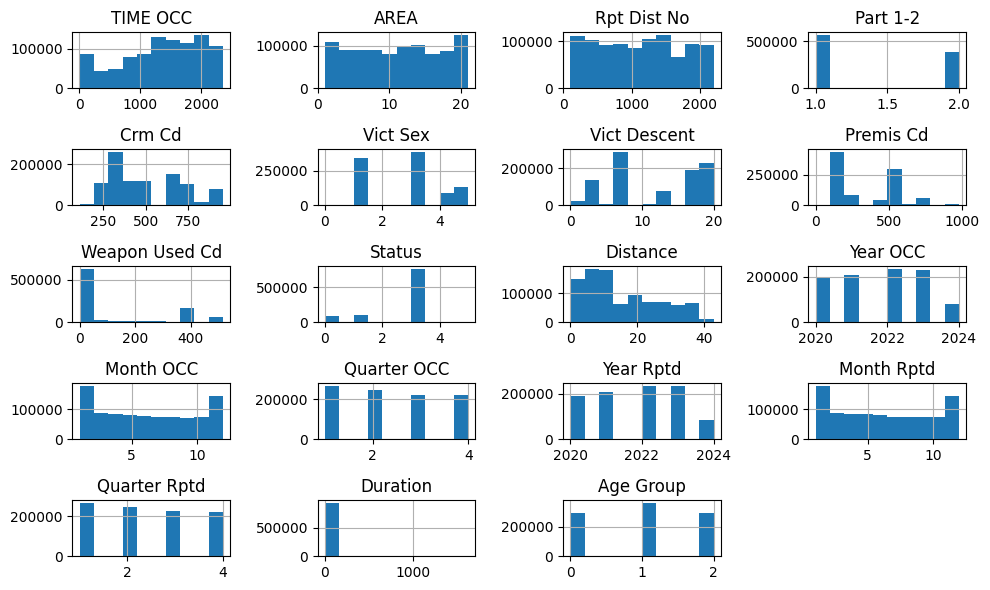

In [63]:
# Vẽ histogram cho từng cột
df.hist(bins=10, figsize=(10, 6))
plt.tight_layout()
plt.show()

In [64]:
df.describe()

,TIME OCC,AREA,Rpt Dist No,Part 1-2,Crm Cd,Vict Sex,Vict Descent,Premis Cd,Weapon Used Cd,Status,Distance,Year OCC,Month OCC,Quarter OCC,Year Rptd,Month Rptd,Quarter Rptd,Duration,Age Group
count,952950.000000,952950.000000,952950.000000,952950.000000,952950.000000,952950.000000,952950.000000,952950.000000,952950.000000,952950.000000,952950.000000,952950.000000,952950.000000,952950.000000,952950.000000,952950.000000,952950.00000,952950.000000,952950.000000
mean,1338.557898,10.718583,1118.296442,1.407083,500.259040,2.640088,11.498659,306.149801,123.711087,2.524962,15.334506,2021.773203,6.239737,2.418681,2021.803889,6.241849,2.41811,11.513369,0.995638
std,652.516752,6.100229,610.076255,0.491291,206.729088,1.400422,6.472828,217.838722,186.786630,1.005895,11.003327,1.255753,3.473995,1.124547,1.259119,3.466057,1.12273,64.312282,0.787152
min,1.000000,1.000000,101.000000,1.000000,110.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024072,2020.000000,1.000000,1.000000,2020.000000,1.000000,1.00000,0.000000,0.000000
25%,900.000000,6.000000,621.000000,1.000000,331.000000,1.000000,7.000000,101.000000,0.000000,3.000000,6.263857,2021.000000,3.000000,1.000000,2021.000000,3.000000,1.00000,0.000000,0.000000
50%,1420.000000,11.000000,1142.000000,1.000000,442.000000,3.000000,12.000000,203.000000,0.000000,3.000000,11.592179,2022.000000,6.000000,2.000000,2022.000000,6.000000,2.00000,1.000000,1.000000
75%,1900.000000,16.000000,1618.000000,2.000000,626.000000,3.000000,17.000000,501.000000,400.000000,3.000000,23.683414,2023.000000,9.000000,3.000000,2023.000000,9.000000,3.00000,2.000000,2.000000
max,2359.000000,21.000000,2199.000000,2.000000,956.000000,5.000000,20.000000,976.000000,516.000000,5.000000,42.727540,2024.000000,12.000000,4.000000,2024.000000,12.000000,4.00000,1630.000000,2.000000


In [65]:
# Các cột cần scale bao gồm: TIME OCC, , Rpt Dist No, Premis Cd, Weapon Used Cd, Distance, Duration.
cols_to_scale = ['TIME OCC', 'Rpt Dist No', 
                  'Premis Cd', 'Weapon Used Cd', 
                 'Distance', 'Duration']
scaler = MinMaxScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

# Kiểm tra tuyến tính

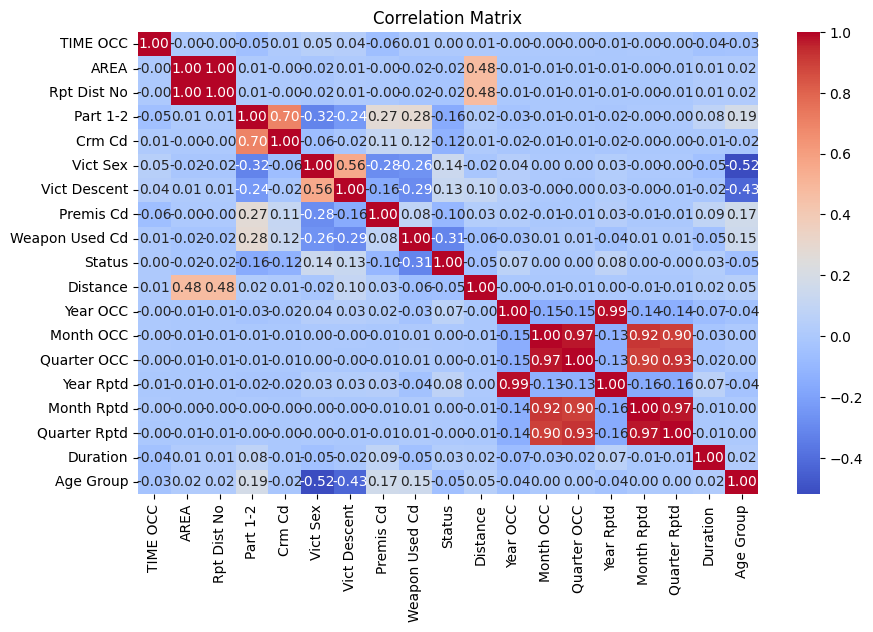

In [66]:
# Chỉ chọn cột số
df_numeric = df.select_dtypes(include=[np.number])

# Tính hệ số tương quan
correlation_matrix = df_numeric.corr()

# Vẽ heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

**Không có hoặc rất ít quan hệ:**

Year OCC vs. Year Rptd: Tương quan gần như hoàn hảo (1.00). Điều này cho thấy năm xảy ra (Year OCC) và năm báo cáo (Year Rptd) gần như giống nhau. **Xóa Year Rptd**

Month OCC vs. Quarter OCC: Tương quan rất cao (0.97). Điều này hợp lý vì quý (Quarter OCC) được tính trực tiếp từ tháng (Month OCC). **Xóa cột Quarter OCC**

Year OCC, Month OCC, và Quarter OCC có tương quan cao với các cột tương ứng của báo cáo (Year Rptd, Month Rptd, Quarter Rptd).

**Không có hoặc rất ít quan hệ:**

Crm Cd vs. Part 1-2: Tương quan trung bình (0.70). Điều này cho thấy loại mã tội phạm (Crm Cd) có quan hệ tuyến tính vừa phải với phần 1 hoặc phần 2 của dữ liệu (Part 1-2).

Distance vs. Rpt Dist No: Tương quan trung bình (0.48). Số liệu này chỉ ra rằng khoảng cách có mối quan hệ nhất định với số khu vực báo cáo (Rpt Dist No).

Vict Sex vs. Vict Descent: Quan hệ trung bình (0.56). Điều này có thể gợi ý rằng giới tính nạn nhân có liên quan đến nhóm sắc tộc của họ.

**Không có hoặc rất ít quan hệ:**
Weapon Used Cd vs. Hầu hết các cột khác: Quan hệ rất thấp (gần 0). Điều này cho thấy việc sử dụng vũ khí hầu như không liên quan đến các đặc trưng khác trong dữ liệu.

TIME OCC với các cột khác: Quan hệ rất thấp (gần 0), cho thấy thời gian xảy ra không ảnh hưởng đáng kể đến các biến khác.

# Chia dữ liệu và huấn luyện 

In [90]:
# Chia dữ liệu thành đặc trưng (X) và nhãn mục tiêu (y)
X = df.drop(columns=["Age Group"])  # Các cột đặc trưng
y = df["Age Group"]  # Cột mục tiêu


# Bước 1: Chia dữ liệu thành tập huấn luyện (80%) và tập kiểm tra (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.2, random_state=42)



# Logistic regression

In [105]:
# Định nghĩa các tham số để tìm kiếm
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],  # Tham số điều chỉnh độ mạnh của regularization
    'solver': ['liblinear', 'saga'],  # Các solver phổ biến trong Logistic Regression
    'max_iter': [100, 200, 300]  # Số lần lặp tối đa
}

# Khởi tạo mô hình Logistic Regression
model = LogisticRegression(multi_class='ovr', max_iter=200)

# Sử dụng GridSearchCV để tìm kiếm tham số tối ưu
grid = GridSearchCV(model, param_grid, scoring='accuracy', cv=3)

# Huấn luyện mô hình với GridSearchCV
grid.fit(X_train, y_train)

# In ra tham số tốt nhất
print("Best parameters:", grid.best_params_)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Best parameters: {'C': 10, 'max_iter': 100, 'solver': 'liblinear'}


In [ ]:
# Dự đoán kết quả trên tập kiểm tra
y_pred = grid.predict(X_test)

# In ra classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.80      0.73     95051
           1       0.51      0.82      0.63    115929
           2       0.51      0.03      0.06     93964

    accuracy                           0.57    304944
   macro avg       0.56      0.55      0.47    304944
weighted avg       0.56      0.57      0.48    304944



# xgboost

In [91]:
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}



# XGBoost model với GPU và early stopping
model_xgb = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=3,
    tree_method="hist",
    device="cuda",
    early_stopping_rounds=10
)

grid = GridSearchCV(
    model_xgb,
    param_grid,
    scoring='accuracy',
    cv=3
)

grid.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

print("Best parameters:", grid.best_params_)

Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}


In [92]:
# Dự đoán trên tập test
y_pred = grid.predict(X_test)

# Đánh giá độ chính xác (accuracy) của mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.4f}")

# Nếu muốn in ra các nhãn dự đoán
print("Predicted labels:", y_pred)

Accuracy on test set: 0.6868
Predicted labels: [2 1 2 ... 1 0 1]


In [93]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
cr = classification_report(y_test, y_pred)
print("Classification Report:")
print(cr)

Confusion Matrix:
[[79515 11116  4420]
 [ 2264 85102 28563]
 [ 1726 47429 44809]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89     95051
           1       0.59      0.73      0.66    115929
           2       0.58      0.48      0.52     93964

    accuracy                           0.69    304944
   macro avg       0.71      0.68      0.69    304944
weighted avg       0.70      0.69      0.69    304944



# lightgbm

In [94]:
# Định nghĩa bộ tham số để GridSearchCV
param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'min_data_in_leaf': [20, 50, 100],
}

# XGBoost model với GPU
model_lgb = lgb.LGBMClassifier(
    objective='multiclass', 
    num_class=3, 
    device='gpu',  # Chạy trên GPU
    gpu_platform_id=0,  # ID của GPU platform, thường là 0
    gpu_device_id=0,  # ID của GPU device, thường là 0
    max_bin=255,  # Tham số bổ sung giúp tối ưu hóa hiệu suất trên GPU
)

# Thiết lập GridSearchCV
grid_lgb = GridSearchCV(
    model_lgb,
    param_grid,
    scoring='accuracy',
    cv=3
)

# Huấn luyện mô hình
grid_lgb.fit(X_train, y_train)

# In ra bộ tham số tốt nhất
print("Best parameters:", grid_lgb.best_params_)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1495
[LightGBM] [Info] Number of data points in the train set: 381180, number of used features: 18
[LightGBM] [Info] Using requested OpenCL platform 0 device 0
[LightGBM] [Info] Using GPU Device: Tesla T4, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...


1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 16 dense feature groups (5.82 MB) transferred to GPU in 0.007055 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -1.164989
[LightGBM] [Info] Start training from score -0.965793
[LightGBM] [Info] Start training from score -1.179629
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 1496
[LightGBM] [Info] Number of data points in the train set: 381180, number of used features: 18
[LightGBM] 

In [103]:
# Dự đoán trên tập test
y_pred = grid.predict(X_test)

# Đánh giá độ chính xác (accuracy) của mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.4f}")

# Nếu muốn in ra các nhãn dự đoán
print("Predicted labels:", y_pred)

[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
Accuracy on test set: 0.6882
Predicted labels: [1 1 2 ... 1 0 1]


In [104]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
cr = classification_report(y_test, y_pred)
print("Classification Report:")
print(cr)

Confusion Matrix:
[[79718 10951  4382]
 [ 2196 85224 28509]
 [ 1723 47327 44914]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89     95051
           1       0.59      0.74      0.66    115929
           2       0.58      0.48      0.52     93964

    accuracy                           0.69    304944
   macro avg       0.71      0.68      0.69    304944
weighted avg       0.70      0.69      0.69    304944



# catboost

In [99]:
from catboost import CatBoostClassifier

# Định nghĩa param_grid cho grid search
param_grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.01, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [3, 5, 7]
}

# Khởi tạo mô hình CatBoost sử dụng GPU
model_cat = CatBoostClassifier(
    loss_function="MultiClass",   # Hàm mất mát cho bài toán phân loại đa lớp
    verbose=100,                  # Cung cấp thông tin chi tiết mỗi 100 vòng huấn luyện
    task_type="GPU",              # Chạy trên GPU
    devices='0',                  # ID của GPU (0 là GPU đầu tiên, nếu có nhiều GPU thì có thể là '0,1')
    random_seed=42                # Đặt seed để tái lập kết quả
)

# GridSearchCV để tìm tham số tốt nhất
grid_cast = GridSearchCV(
    model_cat,                    # Mô hình CatBoost
    param_grid,                   # Dải tham số
    scoring='accuracy',           # Đánh giá mô hình dựa trên độ chính xác
    cv=3                          # Sử dụng k-fold cross-validation (3 fold)
)

# Huấn luyện mô hình với grid search
grid_cast.fit(X_train, y_train)

# In ra tham số tốt nhất
print("Best parameters:", grid_cast.best_params_)

0:	learn: 1.0924957	total: 190ms	remaining: 1m 34s
100:	learn: 0.8284474	total: 840ms	remaining: 3.32s
200:	learn: 0.7668970	total: 1.33s	remaining: 1.99s
300:	learn: 0.7431913	total: 1.81s	remaining: 1.2s
400:	learn: 0.7295271	total: 2.32s	remaining: 572ms
499:	learn: 0.7215879	total: 2.79s	remaining: 0us
0:	learn: 1.0925069	total: 6.36ms	remaining: 3.17s
100:	learn: 0.8290871	total: 512ms	remaining: 2.02s
200:	learn: 0.7672708	total: 1.01s	remaining: 1.5s
300:	learn: 0.7430712	total: 1.51s	remaining: 996ms
400:	learn: 0.7292935	total: 2.01s	remaining: 496ms
499:	learn: 0.7214811	total: 2.5s	remaining: 0us
0:	learn: 1.0925289	total: 6.82ms	remaining: 3.4s
100:	learn: 0.8297259	total: 531ms	remaining: 2.1s
200:	learn: 0.7681595	total: 1.03s	remaining: 1.53s
300:	learn: 0.7450675	total: 1.53s	remaining: 1.01s
400:	learn: 0.7311145	total: 2.05s	remaining: 506ms
499:	learn: 0.7229319	total: 2.55s	remaining: 0us
0:	learn: 1.0402684	total: 6.43ms	remaining: 3.21s
100:	learn: 0.6985597	total

In [100]:
# Dự đoán trên tập test
y_pred = grid_cast.predict(X_test)

# Đánh giá độ chính xác (accuracy) của mô hình
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {accuracy:.4f}")

# Nếu muốn in ra các nhãn dự đoán
print("Predicted labels:", y_pred)

Accuracy on test set: 0.6872
Predicted labels: [[1]
 [1]
 [2]
 ...
 [1]
 [0]
 [1]]


In [101]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification Report
cr = classification_report(y_test, y_pred)
print("Classification Report:")
print(cr)

Confusion Matrix:
[[79841 10811  4399]
 [ 2526 84178 29225]
 [ 1956 46466 45542]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89     95051
           1       0.60      0.73      0.65    115929
           2       0.58      0.48      0.53     93964

    accuracy                           0.69    304944
   macro avg       0.71      0.68      0.69    304944
weighted avg       0.70      0.69      0.69    304944

